# Compare two MSAs

In [1]:
using DelimitedFiles, Plots

In [2]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [3]:
using CUDA
CUDA.device!(0)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(0): TITAN RTX

In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

In [5]:
fam = "PF00397"

path = "/home/louise/MSA/Data/test/PF00397/"
open(path)
L = 31; 

param_file = path * "Parameters_plm_PF00397.dat"
J, H = BpAlignGpu.read_parameters(param_file, q, L, gap=0, typel=typel);

delta = 5;
file_full = path * "PF00397_full_length_sequences.fasta"
file_hmmer = path * "PF00397_full.fasta"
file_hmmer_ins = path * "PF00397_full.inse"
al = BpAlignGpu.enveloptoalign( file_full, file_hmmer, file_hmmer_ins, delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
lambda_file = path * "Lambda_PF00397.dat"
Lambda_all = readdlm(lambda_file)
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];

┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [5]:
fam = "PF00684"
open("/home/louise/MSA/Data/test/PF00684/")
L = 67; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [6]:
function extract_data(namefile::String)
    data = readdlm(namefile);
    param = data[1,:] #param = data[1,1:np]
    nsamp =param[1]

    inds = data[2,1:nsamp];
    res = data[3:end,:];

    xnsols = fill((0,0), L, nsamp)
    for ns in 1:nsamp
        for i=1:L
            x = res[ns,i]
            n = res[ns,L+i]
            xnsols[i,ns] = (x,n)
        end
    end

    sats = []
    ens = []
    seqpas = []
    for (i, idx0) in pairs(inds)
    #    @show i, idx0
        seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
        N = length(al[idx0][2])
        pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

        c = BpAlignGpu.check_sr!(xnsols[:,i], L, N)

        seqsol = BpAlignGpu.convert_soltosequence!(xnsols[:,i], seq.strseq, N, L)
        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        append!(sats, sum(c))
        append!(ens, energy)
        append!(seqpas, [seqsol[1]])
    end
    return param, inds, sats, ens, xnsols, seqpas
end


extract_data (generic function with 1 method)

### Loads MSAs

#### "run_GS" files

In [7]:
path = "data_GS_solutions/"
nsamples = "60"

method = "mf"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param1, inds1, sats1, ens1, xnsols1, seqpas1 = extract_data(namefile);

method = "sce"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param2, inds2, sats2, ens2, xnsols2, seqpas2 = extract_data(namefile);

inds1 == inds2

true

In [8]:
nsamples = "8"
method = "sce"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p5.txt"
param2_d, inds2_d, sats2_d, ens2_d, xnsols2_d, seqpas2_d = extract_data(namefile);


In [9]:
[param2[1:12], param2_d[1:12], inds2_d]

3-element Vector{Vector{Any}}:
 [60, "PF00684", 67, 100, 50, 0.2, 0.001, 1.0e-10, "random", "sce", 800, 0.7]
 [8, "PF00684", 67, 100, 50, 0.5, 0.001, 1.0e-10, "random", "sce", 800, 0.7]
 [17, 21, 38, 48, 50, 56, 57, 60]

In [10]:
j=0
for i in inds2
    if i in inds2_d
        j += 1
        sats2[i] = sats2_d[j]
        ens2[i] = ens2_d[j]
        xnsols2[:,i] = xnsols2_d[:,j]
        seqpas2[i] = seqpas2_d[j]
    end
end

#### "DCAlign" files

In [11]:
nsamples = "60"

namefile = path * "run_GS_"*fam*"_n"*nsamples*"_DCAlign.txt"
res_GS_DCA = readdlm(namefile);


In [12]:
nb_samps_DCA = size(res_GS_DCA,1)

60

In [13]:
inds_DCA = []
sats_DCA = []
ens_DCA = []
seqpas_DCA = []
for i in 1:nb_samps_DCA
    idx0 = res_GS_DCA[i,1]
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    seqsol = (String(res_GS_DCA[i,2]), String(res_GS_DCA[i,3]), res_GS_DCA[i,4], res_GS_DCA[i,5])
    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    
    sat = res_GS_DCA[i,6]    
    append!(inds_DCA, idx0)
    append!(sats_DCA, sat)
    append!(ens_DCA, energy)
    append!(seqpas_DCA, [res_GS_DCA[i,2]])
end
inds_DCA == inds1

true

#### hmmer

In [14]:
inds = inds1

ens_hmmer = []
seqpas_hmmer = []
for (i, idx0) in pairs(inds)
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    seqsol = al[idx0][4]
    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol, pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(ens_hmmer, energy)
    append!(seqpas_hmmer, [al[idx0][3]])
end

# scatter plot of energies

In [15]:
[findall(ens_hmmer-ens1 .< 0), findall(ens_hmmer-ens2 .< 0)]

2-element Vector{Vector{Int64}}:
 [24]
 [24, 48, 60]

In [16]:
id = 60
ens_hmmer[id], ens1[id], ens2[id]

(-68.56604f0, -72.36793f0, -34.99713f0)

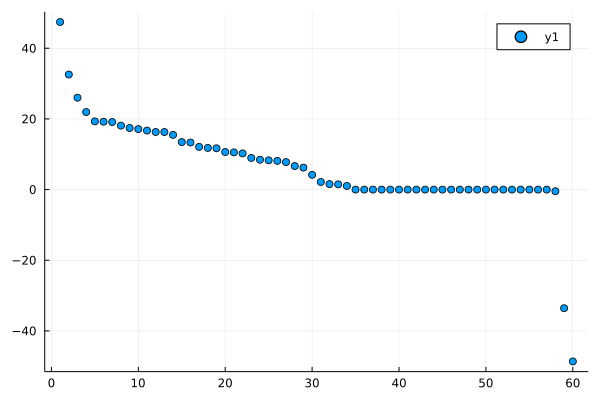

In [17]:
scatter(sort(ens_hmmer-ens2,rev=true))

In [18]:
diffE = ens_hmmer-ens2;

In [19]:
namefile = "data_compareMSA_PF00684_hmmerSCE.txt"
open(namefile, "a") do io
    writedlm(io, [diffE])
end    


# Hamming distance

In [20]:
function hamming_distance(s1::String, s2::String)
    l1 = length(s1)
    l2 = length(s2)
    if l1 != l2
        println("seqs must have same length")
    end
    n = 0
    for i in 1:l1
         if s1[i] != s2[i]
            n += 1
        end
    end
    return n
end

hamming_distance (generic function with 1 method)

In [21]:
MSA1 = seqpas_hmmer
MSA2 = seqpas2

Hdist = []
for i in eachindex(inds1)
    dist = hamming_distance(MSA1[i], MSA2[i])
    #if dist > 0
    #    @show i, dist
    #end
    append!(Hdist, dist)
end

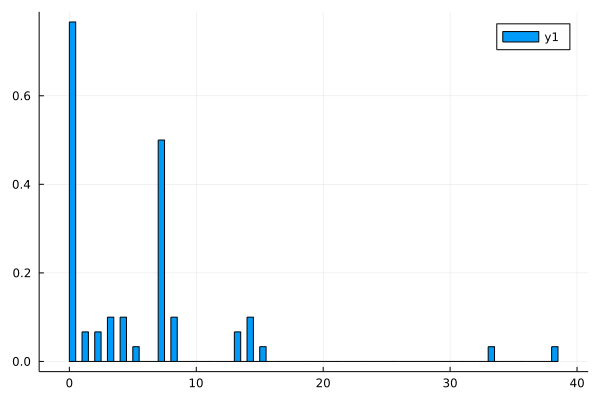

In [22]:
histogram(Hdist, bins = 100, normed = true)

In [23]:
open(namefile, "a") do io
    writedlm(io, [Hdist])
end    


# GAP +/-

In [24]:
function count_gap_pm(s1::String, s2::String)
    l1 = length(s1)
    l2 = length(s2)
    if l1 != l2
        println("seqs must have same length")
    end
    np = 0
    nm = 0
    for i in 1:l1
        if s1[i] !== '-' && s2[i] == '-'
            np += 1
        end
        if s1[i] == '-' && s2[i] !== '-'
            np += 1
        end
    end
    return np, nm
end

count_gap_pm (generic function with 1 method)

In [25]:
id = 60
@show seqpas_hmmer[id] == seqpas2[id]
@show seqpas_hmmer[id]
@show seqpas2[id]
count_gap_pm(seqpas_hmmer[id], seqpas2[id])

seqpas_hmmer[id] == seqpas2[id] = false
seqpas_hmmer[id] = "CPDCHGRGYEAISTEICPVCKGKGKSKSVS-EIDSFL-KNGAVCEKCKGKGSI-EVTRPCEACEGL-"
seqpas2[id] = "CPVCKGKG---K-SKSVDFMKISEK-DIDS--FLK--NG--AVCEKCKG-KGSIEVTRPCEACEGLG"


(14, 0)

In [26]:
MSA1 = seqpas_hmmer
MSA2 = seqpas2

Gp = []
Gm = []
for i in eachindex(inds1)
    np, nm = count_gap_pm(MSA1[i], MSA2[i])
    append!(Gp, np)
    append!(Gm, nm)
end

In [27]:
sum(Gm)

0

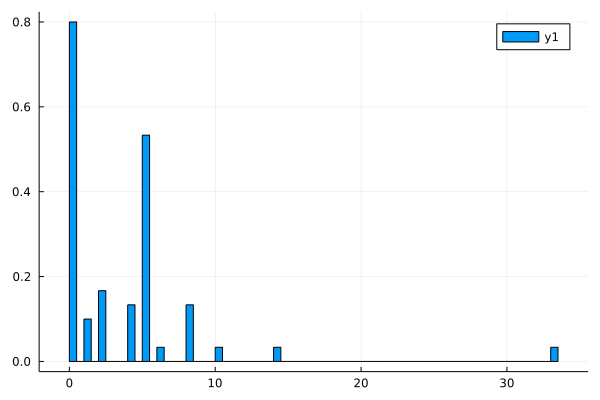

In [28]:
histogram(Gp, bins = 100, normed = true)

In [29]:
open(namefile, "a") do io
    writedlm(io, [Gp])
    writedlm(io, [Gm])
end    


# Mismatch

In [30]:
function count_mismatch(s1::String, s2::String)
    l1 = length(s1)
    l2 = length(s2)
    if l1 != l2
        println("seqs must have same length")
    end
    m = 0
    for i in 1:l1
        if s1[i] !== '-' && s2[i] !== '-'
            #@show i, s1[i], s2[i] 
            if s1[i] !== s2[i]
                m += 1
            end
        end
    end
    return m
end

count_mismatch (generic function with 1 method)

In [31]:
id = 45
@show seqpas_hmmer[id] == seqpas2[id]
@show seqpas_hmmer[id]
@show seqpas2[id]
count_mismatch(seqpas_hmmer[id], seqpas2[id])

seqpas_hmmer[id] == seqpas2[id] = false
seqpas_hmmer[id] = "CESCHGSGAAAGSPETCPTCGGSGTIRTTERTLG--TMQVQKTCPRCGGKGKII--GSPCTSCGGQG"
seqpas2[id] = "CESCHGSGAAAGSPETCPTCGGSGTIRTTERTLGTMQ--VQKTCPRCGGKGKII--GSPCTSCGGQG"


1

In [32]:
MSA1 = seqpas_hmmer
MSA2 = seqpas1

Mism = []
for i in eachindex(inds1)
    m = count_mismatch(MSA1[i], MSA2[i])
    append!(Mism, m)
end

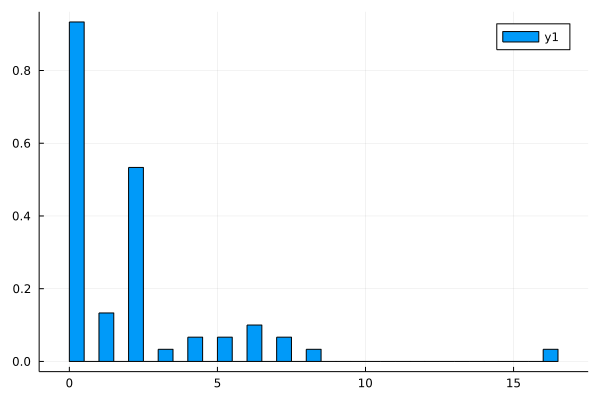

In [33]:
histogram(Mism, bins = 50, normed = true)

In [34]:
open(namefile, "a") do io
    writedlm(io, [Mism])
end    


# Proximity

In [ ]:
MSA1 = seqpas_hmmer